# Why do we need a Drowsiness detection mechanism for drivers?
(my personal inspiration for this project)
## #1 From a personal pov
My father is a really smooth and the best driver in my opinion.And , I don't have my driving license yet so I have to add this brief personal anecdote w a pinch of father-praising hehe. Doesnt matter which road he has taken, i always feel the safest when he is driving in comparison to riding any0ne else. <br>But it just so happens that, he sometimes feels drowsy when he is on his way from a long day of work, and there have been times when he nearly lost a signal or two because of this. Now, I am grateful that he is safe due to his alertness ,but the question arises could this problem of fatigue consequenced drowsiness lead to any other severe implications?
And this question was the leading inspiration for me to build a "Driver -Drowsiness detection system" w an inbuilt alarm which goes off whenever one is on the road and in any state of fatigue, and to prevent him from crashes or accidents of any kind.

## #2 Statistical pov
Statistically, 1 in 4 car crashes are  a result of **sleep-deprived fatigue** and lack of concentration. Drowsiness has been estimated to be involved in **40 %  of crashes on motorways**. Fall-asleep crashes are very serious in terms of injury severity and more likely to occur in sleep-deprived individuals.And with the current scenario, a majority of people suffer from this issue of sleep-deprivation due to the global  increase in busy working lifestyle of people everywhere.<br>
Hence I picked this problem statement to see to what extent can we solve this issue and avoid on-road drowsiness.<br>


In [32]:
# install dlib (will take 10 or more minutes)
!apt update
!apt install -y cmake
!pip install dlib

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 108 kB in 2s (54.1 kB/s)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
12 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree..

In [21]:
# Mounting the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In Google Drive, please create the below directory <br>
Colab Notebooks/Drowsiness_Detection/

In [22]:
# Importing Libraries
import sys
from google.colab import output

# Google Drive Path
gDrivePath = "gdrive/MyDrive/Colab Notebooks/Drowsiness_Detection/"
sys.path.append(gDrivePath)

In [23]:
# Importing Libraries
from utils import video_stream
from utils import video_frame
from utils import js_to_image
from utils import Resize

import dlib
from google.colab.patches import cv2_imshow
from IPython.display import Audio

from scipy.spatial import distance as dist
from threading import Thread
from collections import OrderedDict
import numpy as np
import argparse
import time
import cv2

In [24]:
# Loading the dlib face regions predictor
dlib_shape_pred = gDrivePath + "dlib_shape_predictor/shape_predictor_68_face_landmarks.dat"

In [25]:
# Defining the Face region coordinates in an ordered dictionary
FACE_REGIONS_INDEXS = OrderedDict([
	("mouth", (48, 68)),
	("inner_mouth", (60, 68)),
	("right_eyebrow", (17, 22)),
	("left_eyebrow", (22, 27)),
	("right_eye", (36, 42)),
	("left_eye", (42, 48)),
	("nose", (27, 36)),
	("jaw", (0, 17))
])

In [26]:
# Method to convert the facial landmarks of x,y coordinates to numpy array
def shape_to_np_array(shape, dtype="int"):
	# Initializing the list of (x, y) coordinates
	coordnts = np.zeros((shape.num_parts, 2), dtype=dtype)

	# Looping over all the facial landmarks and convert them to a tuple of (x, y) coordinates
	for i in range(0, shape.num_parts):
		coordnts[i] = (shape.part(i).x, shape.part(i).y)

	# Returning the list of (x, y) coordinates
	return coordnts

In [27]:
# Method to calculate the ratio of distances between the vertical eye landmarks and the distances between the horizontal eye landmarks
# The concept behind EAR is : The return value of the eye aspect ratio will be almost constant when the eye is open.
## However the value will decrease rapidly towards zero during a blink.
### If the eye is closed, the eye aspect ratio will again remain almost constant, but will be significantly smaller compared to the ratio when the eye is open.
def eye_aspect_ratio(eye):
	# compute the euclidean distances between the two sets of vertical eye landmarks (x, y) coordinates
	A = dist.euclidean(eye[1], eye[5])
	B = dist.euclidean(eye[2], eye[4])
	# compute the euclidean distances between the horizontal eye landmark (x, y) coordinates
	C = dist.euclidean(eye[0], eye[3])
	# compute the final eye aspect ratio
	ear = (A + B) / (2.0 * C)
	# return the eye aspect ratio
	return ear

In [28]:
# Defining two constants, one for the eye aspect ratio thresold number below which if it goes then the eye blinked and a second constant for the number of consecutive
# frames the eye must be below the threshold value for the alarm to set off
# Remember to play around with the below values to check for the right value that works for you as it differs from system to system depending on hardware
# configuration and CPU/GPU processing power and webcam/camera video quality.
EYE_EAR_THRESHOLD = 0.2
EYE_EAR_CONSECU_FRAMES = 5

# Initializing the frame counter and setting the alarm on indicator to false
COUNTER = 0
ALARM_ON = False

# Initializing the dlib's face detector and facial landmark predictor
print("loading the facial landmark predictor...")
face_detector = dlib.get_frontal_face_detector()
facial_landmark_predictor = dlib.shape_predictor(dlib_shape_pred)

loading the facial landmark predictor...


In [29]:
# Capturing the indexes of the facial landmarks for the left and right eye
(leStart, leEnd) = FACE_REGIONS_INDEXS["left_eye"]
(reStart, reEnd) = FACE_REGIONS_INDEXS["right_eye"]

In [33]:
# Method to play the alarm beep sound in case of drowsiness
def run():
    while True:
        output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
        global stop_threads
        if stop_threads:
            break

Starting video stream thread...


<IPython.core.display.Javascript object>

Drowsiness Alert..


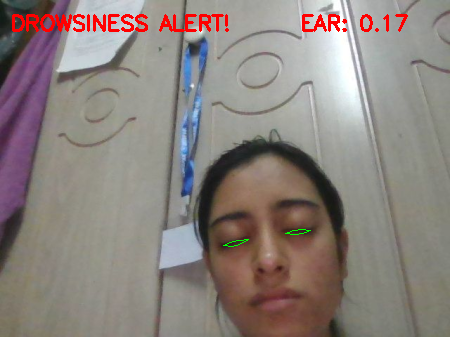

Drowsiness Alert..


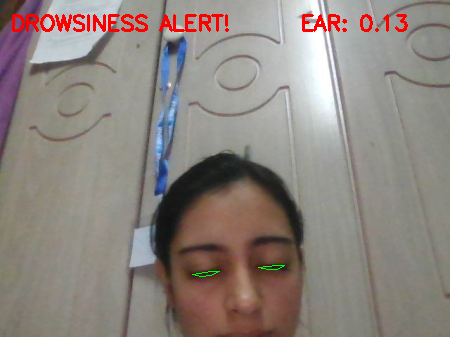

KeyboardInterrupt: ignored

In [34]:
# Starting the video stream thread
print("Starting video stream thread...")
video_stream()
label_html = 'Capturing...'
bbox = ''
time.sleep(1.0)
COUNTER=0
ALARM_ON = False

# Looping over the frames from the video stream
while True:

	# On each frame of the video file stream, resizing it, and converting it to grayscale
	vs = video_frame(label_html, bbox)
	frame = js_to_image(vs["img"])
	frame = Resize(frame, width=450)
	gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

	# Detecting faces using dlib detector in the grayscale frame
	rects = face_detector(gray, 0)

	# Looping over the face detections
	for rect in rects:

		# Extracting the facial landmarks from the face region, then converting the facial landmarks (x,y) coordinates to a NumPy array
		shape = facial_landmark_predictor(gray, rect)
		shape = shape_to_np_array(shape)

		# Extracting the left and right eye coordinates to compute the eye aspect ratio for both the eyes
		leftEye = shape[leStart:leEnd]
		rightEye = shape[reStart:reEnd]
		leftEAR = eye_aspect_ratio(leftEye)
		rightEAR = eye_aspect_ratio(rightEye)

		# Calculating the average of the eye aspect ratio together for both eyes
		ear = (leftEAR + rightEAR) / 2.0

  	# Verifying if the eye aspect ratio is below the blink threshold, if so then incrementing the blink frame counter
		if ear < EYE_EAR_THRESHOLD:
			COUNTER += 1

			# If the eyes are closed for a sufficient number of frames then sound the alarm
			if COUNTER >= EYE_EAR_CONSECU_FRAMES:

				# If the alarm is not on, then switch it on
				if not ALARM_ON:
					ALARM_ON = True

					# Initializing the stop thread to false
					stop_threads = False

					# Running the run method on a separate thread to play the alarm
					t = Thread(target=run)
					print("Drowsiness Alert..")
					t.deamon = True
					t.start()

					# Stopping and killing the thread after playing the sound
					stop_threads = True
					t.join()

					# Initializing the counter and alarm_on indicator back to initial state
					COUNTER = 0
					ALARM_ON = False

					# Computing the convex hull for the left and right eye, then visualizing both the eyes
					leftEyeHull = cv2.convexHull(leftEye)
					rightEyeHull = cv2.convexHull(rightEye)
					cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
					cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)

					# Drawing an alarm and printing EAR on the screenshot
					cv2.putText(frame, "DROWSINESS ALERT!", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
					cv2.putText(frame, "EAR: {:.2f}".format(ear), (300, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

					# show the frame
					cv2_imshow(frame)

		# or else, the eye aspect ratio is not below the blink threshold, so reset the counter and alarm
		else:
			COUNTER = 0
			ALARM_ON = False

	key = cv2.waitKey(1) & 0xFF

	# If the `q` key was pressed, break from the loop
	if key == ord("q"):
		break

# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()